In [1]:
import networkx as nx
import pandas as pd
import random as rand
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.gridspec as gridspec
from collections import Counter
from tqdm.notebook import tqdm
import altair as alt

In [2]:
rand.seed(761)

In [3]:
class Agent:
    """
    Initializes an agent with
    opinion        1, 2, or 3 (no opinion, disinformation, fact-checkers)
    status         "S", "I", "uI", "R" or "aR" (susceptible, infected, resistant)
    share          True or False (can the node actively shares information?)
    frequency      (int) (how much is shared per share call)
    resistance     True or False (is the node able to change its opinion?)
    dark           True or False (is the node a dark agent?)

    that can believe and/or share their opinion
    and can output their network information
    """

    def __init__(self, opinion=0, status="S", shares=.5, frequency=1, resistance=False, dark=False):
        """
        [default]
        opinion: (int)
            [0]: no opinion
            1: disinformation
            2: fact checking
        status: (str)
            ["S"]: susceptible
            "I": infected
            "R": resistant
        share: (bool)
            [True]: can share their opinion
            False: can't share their opinion
        frequency: (int)
            [1]: how often the opinion is shared per share call
        resistance: (bool)
            True: can't change their opinion
            [False]: can change their opinion
        dark: (bool)
            True: is a 'dark agent' that can trigger disinformation campaigns
            [False]: not a dark agent
        """
        self.opinion = opinion
        self.status = status
        self.shares = shares
        self.frequency = frequency
        self.resistance = resistance

        self.dark = dark
        self.active_attack = False
        self.pause = False
        self.attack_frequency = 50

        self.prop_1 = .5
        self.prop_2 = 1
        self.prop_vax = 0

        self.friends = []
        self.node_id = None

        self.opinion_history = []
        self.engagement = []
        self.next_opinion = False

    def share(self):
        """
        Defines the sharing behavior of nodes:
        Either has no opinion,
        shares disinformation,
        or fact checking information
        """

        self.engagement = []

        if rand.random() <= self.shares:
            if self.opinion == 0:
                self.engagement = [0 for _ in range(self.frequency)]
            elif self.opinion == 2:
                self.engagement = [2 for _ in range(self.frequency)]
            elif self.opinion == 1:
                self.engagement = [1 for _ in range(self.frequency)]
            else:
                raise ValueError

    def check_friends(self):
        """
        Based on the neighbouring nodes, the status of the node under consideration is updated
        """
        if not self.resistance:
            all_opinions = []
            for friend in self.friends:
                all_opinions.extend(friend.engagement)

            count = Counter(all_opinions)

            if not self.resistance:
                n_1 = count.get(1)

                if n_1:
                    prop = n_1 / len(all_opinions)

                    if prop > self.prop_1:
                        self.next_opinion = 1
                        self.status = "I"
                        self.resistance = True

                    else:
                        self.next_opinion = self.opinion

                else:
                    self.next_opinion = self.opinion

            else:
                self.next_opinion = self.opinion

            n_2 = count.get(2)

            if n_2:

                if not self.resistance:

                    if rand.random() < self.prop_2:
                        self.resistance = True
                        self.status = "R"
                        self.next_opinion = 0

                        if rand.random() < self.prop_vax:
                            self.next_opinion = 2
                            self.status = 'aR'

                    else:
                        self.next_opinion = self.opinion

        else:
            self.next_opinion = self.opinion

    def update_opinion(self):
        """
        Records and changes the opinion of the node (from no opinion to either infected or resistant)
        """
        self.opinion_history.append(self.opinion)
        self.opinion = self.next_opinion

    def node_output(self):
        """
        Status of the node that can be requested.
        """

        return (
            self.node_id,
            dict(
                opinion=self.opinion,
                status=self.status,
                share=self.share,
                resistance=self.resistance,
                dark=self.dark,
            )
        )

    def tie_output(self):
        """
        List of neighbouring friends of a node that can be requested.
        """
        tie_list = []
        for friend in self.friends:
            tie_list.append((
                self.node_id,
                friend.node_id
            ))

        return tie_list

    def attack(self, tick, kind=0, start=5, attack_length=5, decay=10):
        """
        [default]
        tick: (int)
            time steps in the model
        kind: (int)
            [0]: node shares no opinion
            1: node shares disinformation
            2: node shares fact-checking
        start: (int)
            [5]: beginning of the attack at time step
        attack_length: (int)
            [5]: duration of an attack in time steps
        decay: (int)
            [10]: decrease of attack intensity depending on which stereotype is used as blueprint for the dark agent's behavior
        """
        if self.dark:

            if kind == 0:
                if tick == start:
                    self.frequency = self.attack_frequency
                    self.share()
                    self.frequency = 1
                else:
                    self.share()

            elif kind == 1:
                if tick == start:
                    self.active_attack = attack_length - 1
                    freq = self.attack_frequency
                    for a in range(self.active_attack):
                        if freq > 0:
                            freq -= decay
                    self.attack_frequency = freq
                    self.frequency = self.attack_frequency
                    self.share()
                    self.frequency = 1
                    self.pause = True

                else:
                    if self.active_attack:
                        if self.pause:
                            self.share()
                            self.pause = False
                        else:
                            self.attack_frequency += decay
                            self.frequency = self.attack_frequency
                            self.share()
                            self.frequency = 1
                            self.pause = True
                            self.active_attack -= 1
                            if self.active_attack < 1:
                                self.active_attack = False
                    else:
                        self.share()

            elif kind == 2:
                if tick == start:
                    self.active_attack = attack_length - 1
                    self.frequency = self.attack_frequency
                    self.share()
                    self.frequency = 1
                    self.pause = True

                else:
                    if self.active_attack:
                        if self.pause:
                            self.frequency = self.attack_frequency
                            self.share()
                            self.frequency = 1
                            self.pause = False
                        else:
                            if self.attack_frequency > 0:
                                self.attack_frequency -= decay

                            self.frequency = self.attack_frequency
                            self.share()
                            self.frequency = 1
                            self.pause = True
                            self.active_attack -= 1
                            if self.active_attack < 1:
                                self.active_attack = False
                    else:
                        self.share()

            else:
                self.share()

    def alter_agent(self, kind='dark', attack_strength=50):
        """
        Change the status of the agent 
        [default]
        kind: (str)
            ['dark']: dark agent type
            'light': fact-checking sharing agent

        attack_strength: (int)
            [50]: intensity of the attack
        """

        if kind == 'dark':
            self.opinion = 1
            self.status = 'uI'
            self.shares = 1
            self.frequency = 1
            self.resistance = True
            self.dark = True
            self.attack_frequency = attack_strength

        elif kind == 'light':
            self.opinion = 2
            self.status = 'aR'
            self.shares = 1
            self.frequency = 1
            self.resistance = True
            self.dark = False

In [4]:
def run_model(
        pop_size=100,
        n_ticks=20,
        n_friends=5,
        n_add=5,
        share_prob=.5,

        attack_start=5,
        attack_kind=0,
        atk_len=5,
        atk_str=50,
        decay=10,
        dark_quantile=.75,

        prebunk_prob=1.0,
        vax_prob=0.0,

        node_mult=50,

        draw=True,
        verbose=True,

        custom_title='Title',
        file_name='savefig'
):
    """
    Simulate the user network with the defined properties
    [default]
    pop_size: (int)
        [100]:number of the nodes in the user networks
    n_ticks: (int)
        [20]: number of time steps conducted in the simulation
    n_friends: (int)
        [5]: maximum number of friends a user can have
    n_add: (int)
        [5]: Number of times an agent to which an edge is established should be added to the list of already selected target agents
    share_prob: (float)
        [0.5]: probability to share a node's opinion with its neighbour
    attack_start: (int)
        [5]: time step when the attacks start
    attack_kind: (int)
        [0]: type of attack executed by the dark agents, i.e., which kind of stereotype is used as blueprint
    atk_len: (int)
        [5]: time steps the attack lasts
    atk_str: (int)
        [50]: number of messages shared during an attack
    decay: (int)
        [10]: decrease of attack intensity depending on which stereotype is used as blueprint for the dark agent's behavior
    dark_quantile: (float)
        [0.75]: percentile of in-degrees of edges that determines which node is the dark agent
    prebunk_prob: (float)
        [1.0]: a node's probability to become a prebunking agent themselves
    vax_prob: (float)
        [0.0]: a node's probability to change their status to resistant
    node_mult: ()
        [5]: magnification factor of nodes in the plot
    draw: (bool)
        [True]: after the simulation concluded, should a plot be created?
    verbose: (bool)
        [True]: should the status of the simulation be updated in the console?
    custom_title: (str)
        ['Title']: the title of the plot
    file_name: (str)
        ['savefig']: the name of the file the plot is stored into
    """
    # Create the population
    if verbose:
        print('initializing population')

    population = []
    chosen = []
    for i in range(pop_size):
        agent = Agent()
        agent.node_id = i
        agent.shares = share_prob
        agent.prop_2 = prebunk_prob
        agent.prop_vax = vax_prob
        population.append(agent)
        chosen.append(agent)

    if verbose:
        print('initializing friends')
    for i in range(n_friends):
        for agent in population:
            n_friends = i + 1
            while len(agent.friends) < n_friends:
                fr = rand.choice(chosen)
                if fr == agent:
                    continue
                elif fr in agent.friends:
                    continue
                else:
                    agent.friends.append(fr)
                    for k in range(n_add):
                        chosen.append(fr)

    if verbose:
        print('initializing light and dark')
    light = Counter(chosen).most_common(1)[0][0]

    c = Counter(chosen)
    n_list = []
    for k in c.keys():
        n_list.append(c[k])
    med_in = np.quantile(n_list, dark_quantile, method='nearest')
    m_list = []
    for k in c.keys():
        if c[k] == med_in:
            m_list.append(k)

    dark = rand.choice(m_list)

    light.alter_agent('light')
    dark.alter_agent('dark', attack_strength=atk_str)

    if verbose:
        print('initial plots')
    node_list = []
    tie_list = []
    for agent in population:
        node_list.append(agent.node_output())
        tie_list.extend(agent.tie_output())

    if draw:
        g = nx.DiGraph()
        g.add_nodes_from(node_list)
        g.add_edges_from(tie_list)

        status_dict = {
            "S": 'grey',
            "R": 'lightgreen',
            "aR": 'darkgreen',
            "I": 'red',
            "uI": 'darkred'
        }

        colors = [status_dict[g.nodes[val]['status']] for val in g.nodes]
        degrees = [val * node_mult for (node, val) in g.degree()]
        lay = nx.spring_layout(g)  # , weight = 50)
        fig = plt.figure(figsize=(15, 15))
        gs = gridspec.GridSpec(3, 3, height_ratios=[1, .4, .4], width_ratios=[1, 1, .1])

        n_s = []
        n_i = []
        n_r = []
        n_ui = []
        n_ar = []

        e_s = []
        e_i = []
        e_r = []

        ns = 0
        ni = 0
        nr = 0
        nar = 0
        nui = 0

        for agent in population:
            if agent.status == 'S':
                ns += 1
            elif agent.status == 'I':
                ni += 1
            elif agent.status == 'R':
                nr += 1
            elif agent.status == 'uI':
                nui += 1
            elif agent.status == 'aR':
                nar += 1
            else:
                raise ValueError

        n_s.append(ns)
        n_i.append(ni)
        n_r.append(nr)
        n_ar.append(nar)
        n_ui.append(nui)

        es = 0
        ei = 0
        er = 0

        e_s.append(es)
        e_i.append(ei)
        e_r.append(er)

        net_start = fig.add_subplot(gs[0])
        nx.draw_networkx_nodes(g, pos=lay, ax=net_start, node_size=degrees, node_color=colors, alpha=.75)
        nx.draw_networkx_edges(g, pos=lay, arrows=True, ax=net_start, node_size=degrees, alpha=.3)
        nx.draw_networkx_labels(g, pos=lay, font_size=8)
        net_start.set_title('a)', loc='left')

    if verbose:
        print('run model')
    for tick in range(n_ticks):

        for agent in population:
            if agent.dark:
                agent.attack(tick=tick, kind=attack_kind, start=5, attack_length=atk_len, decay=decay)
            else:
                agent.share()

        for agent in population:
            agent.check_friends()

        for agent in population:
            agent.update_opinion()

        # The code below is solely for plotting purposes
        if draw:
            ns = 0
            ni = 0
            nr = 0
            nui = 0
            nar = 0

            # S, I, uI, R, aR

            for agent in population:
                if agent.status == 'S':
                    ns += 1
                elif agent.status == 'I':
                    ni += 1
                elif agent.status == 'R':
                    nr += 1
                elif agent.status == 'uI':
                    nui += 1
                elif agent.status == 'aR':
                    nar += 1
                else:
                    raise ValueError

            es = 0
            ei = 0
            er = 0

            for agent in population:
                if agent.opinion == 0:
                    # ns+=1
                    es += len(agent.engagement)
                    agent.engagement = []
                elif agent.opinion == 1:
                    # ni+=1
                    ei += len(agent.engagement)
                    agent.engagement = []
                elif agent.opinion == 2:
                    # nr+=1
                    er += len(agent.engagement)
                    agent.engagement = []

            n_s.append(ns)
            n_i.append(ni)
            n_r.append(nr)
            n_ar.append(nar)
            n_ui.append(nui)

            e_s.append(es)
            e_i.append(ei)
            e_r.append(er)

    if draw:
        node_list = []
        tie_list = []
        for agent in population:
            node_list.append(agent.node_output())
            tie_list.extend(agent.tie_output())

        g = nx.DiGraph()
        g.add_nodes_from(node_list)
        g.add_edges_from(tie_list)

        status_dict = {
            "S": 'grey',
            "R": 'lightgreen',
            "aR": 'darkgreen',
            "I": 'pink',
            "uI": 'darkred'
        }

        colors = [status_dict[g.nodes[val]['status']] for val in g.nodes]
        degrees = [val * node_mult for (node, val) in g.degree()]

        net_end = fig.add_subplot(gs[1])
        nx.draw_networkx_nodes(g, pos=lay, ax=net_end, node_size=degrees, node_color=colors, alpha=.75)
        nx.draw_networkx_edges(g, pos=lay, arrows=True, ax=net_end, node_size=degrees, alpha=.3)
        nx.draw_networkx_labels(g, pos=lay, font_size=8)
        net_end.set_title('b)', loc='left')

        net_legend = fig.add_subplot(gs[2])
        legend_elements = [
            lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=15, label='susceptible'),
            lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkgreen', markersize=15, label='prebunking agent'),
            lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=15, label='immunized'),
            lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkred', markersize=15, label='dark agent'),
            lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='pink', markersize=15, label='infected'),
        ]

        net_legend.legend(handles=legend_elements, loc='upper left')
        net_legend.axis('off')

        vol_share = fig.add_subplot(gs[3:5])

        vol_share.plot(e_s, color='grey')
        vol_share.plot(e_i, color='red')
        vol_share.plot(e_r, color='green')
        vol_share.set_title('c)', loc='left')
        vol_share.set_xlabel('model steps', loc='center')
        vol_share.set_ylabel('shares')

        vol_share_legend = fig.add_subplot(gs[5])
        legend_elements = [lines.Line2D([0], [0], color='grey', lw=4, label='opinion 0'),
                           lines.Line2D([0], [0], color='red', lw=4, label='opinion 1'),
                           lines.Line2D([0], [0], color='green', lw=4, label='opinion 2')]
        vol_share_legend.legend(handles=legend_elements, loc='upper left')
        vol_share_legend.axis('off')

        n_agents = fig.add_subplot(gs[6:8])

        n_agents.plot(n_s, color='grey')
        n_agents.plot(n_i, color='pink')
        n_agents.plot(n_r, color='lightgreen')
        n_agents.plot(n_ar, color='darkgreen')
        n_agents.plot(n_ui, color='darkred')
        n_agents.set_title('d)', loc='left')
        n_agents.set_xlabel('model steps', loc='center')
        n_agents.set_ylabel('proportion of agents (%)')

        n_agents_legend = fig.add_subplot(gs[8])
        legend_elements = [
            lines.Line2D([0], [0], color='grey', lw=4, label='susceptible'),
            lines.Line2D([0], [0], color='darkgreen', lw=4, label='prebunking agent'),
            lines.Line2D([0], [0], color='lightgreen', lw=4, label='immunized'),
            lines.Line2D([0], [0], color='darkred', lw=4, label='dark agent'),
            lines.Line2D([0], [0], color='pink', lw=4, label='infected'),
        ]

        # Create the figure
        n_agents_legend.legend(handles=legend_elements, loc='upper left')
        n_agents_legend.axis('off')

    count_s = 0
    count_i = 0
    count_r = 0
    for agent in population:
        if agent.status == 'S':
            count_s += 1
        elif agent.status == 'I':
            count_i += 1
        elif agent.status == 'uI':
            count_i += 1
        elif agent.status == 'R':
            count_r += 1
        elif agent.status == 'aR':
            count_r += 1
        else:
            raise ValueError

    info_dict = dict(
        pop_size=pop_size,
        n_ticks=n_ticks,
        n_friends=n_friends,
        n_add=n_add,

        attack_start=attack_start,
        attack_kind=attack_kind,
        dark_quantile=dark_quantile,

        prebunk_prob=prebunk_prob,
        vax_prob=vax_prob,

        n_s=count_s,
        n_i=count_i,
        n_r=count_r
    )
    if draw:
        fig.suptitle(custom_title)
        fig.tight_layout()

        fig.savefig(file_name, dpi=300)

    if verbose:
        print(info_dict)

    return info_dict

{'pop_size': 100,
 'n_ticks': 100,
 'n_friends': 5,
 'n_add': 5,
 'attack_start': 5,
 'attack_kind': 0,
 'dark_quantile': 0.75,
 'prebunk_prob': 0.3,
 'vax_prob': 0.1,
 'n_s': 2,
 'n_i': 33,
 'n_r': 65}

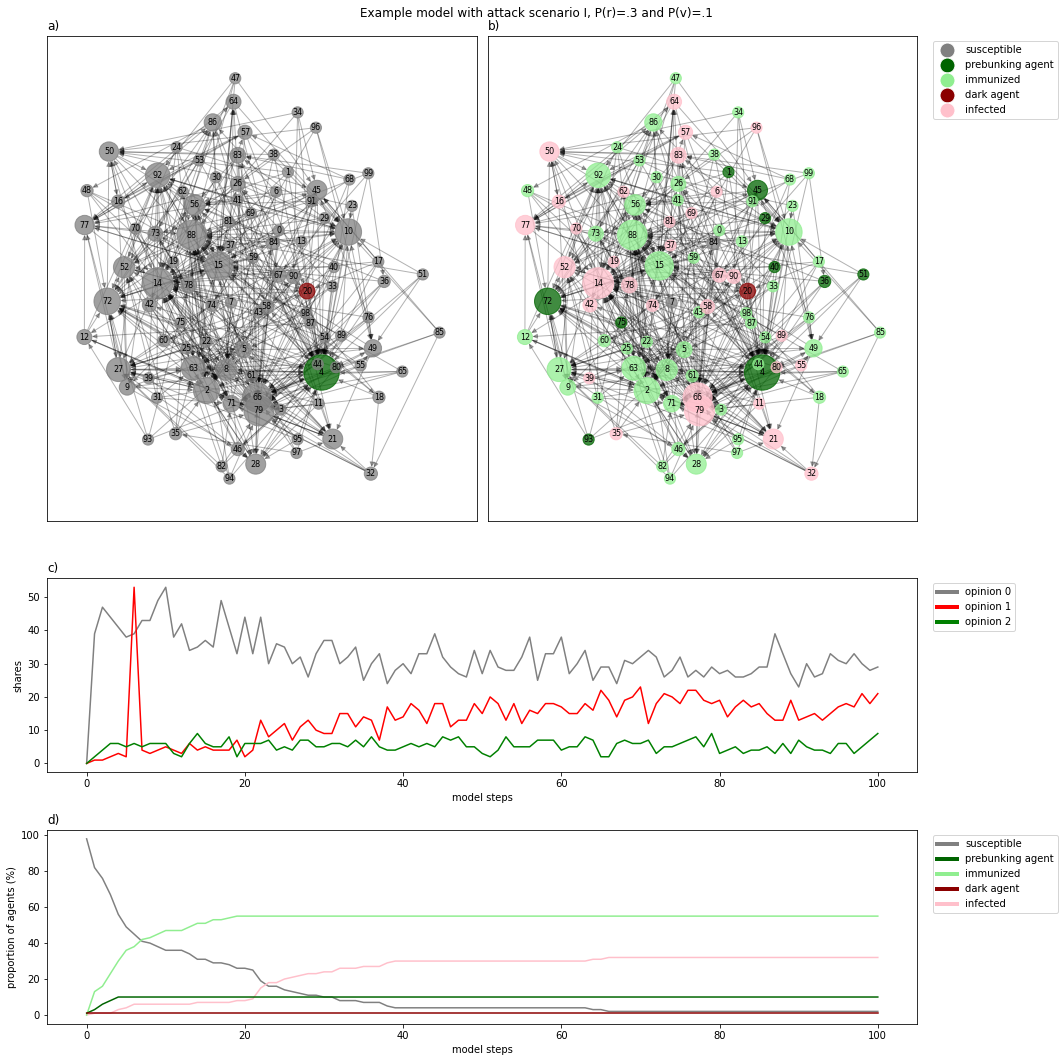

In [8]:
run_model(
    pop_size=100,
    n_ticks=100,
    n_friends=5,
    n_add=5,
    share_prob=.5,

    attack_start=5,
    attack_kind=0,
    atk_len=5,
    atk_str=50,
    decay=10,
    dark_quantile=.75,

    prebunk_prob=.3,
    vax_prob=.1,
    # draw = False,
    verbose=False,
    node_mult=25,
    custom_title='Example model with attack scenario I, P(r)=.3 and P(v)=.1',
    file_name='/home/dobby/Debunking/notebooks/figures/atk_1'
)

{'pop_size': 100,
 'n_ticks': 100,
 'n_friends': 5,
 'n_add': 5,
 'attack_start': 5,
 'attack_kind': 1,
 'dark_quantile': 0.75,
 'prebunk_prob': 0.3,
 'vax_prob': 0.4,
 'n_s': 1,
 'n_i': 12,
 'n_r': 87}

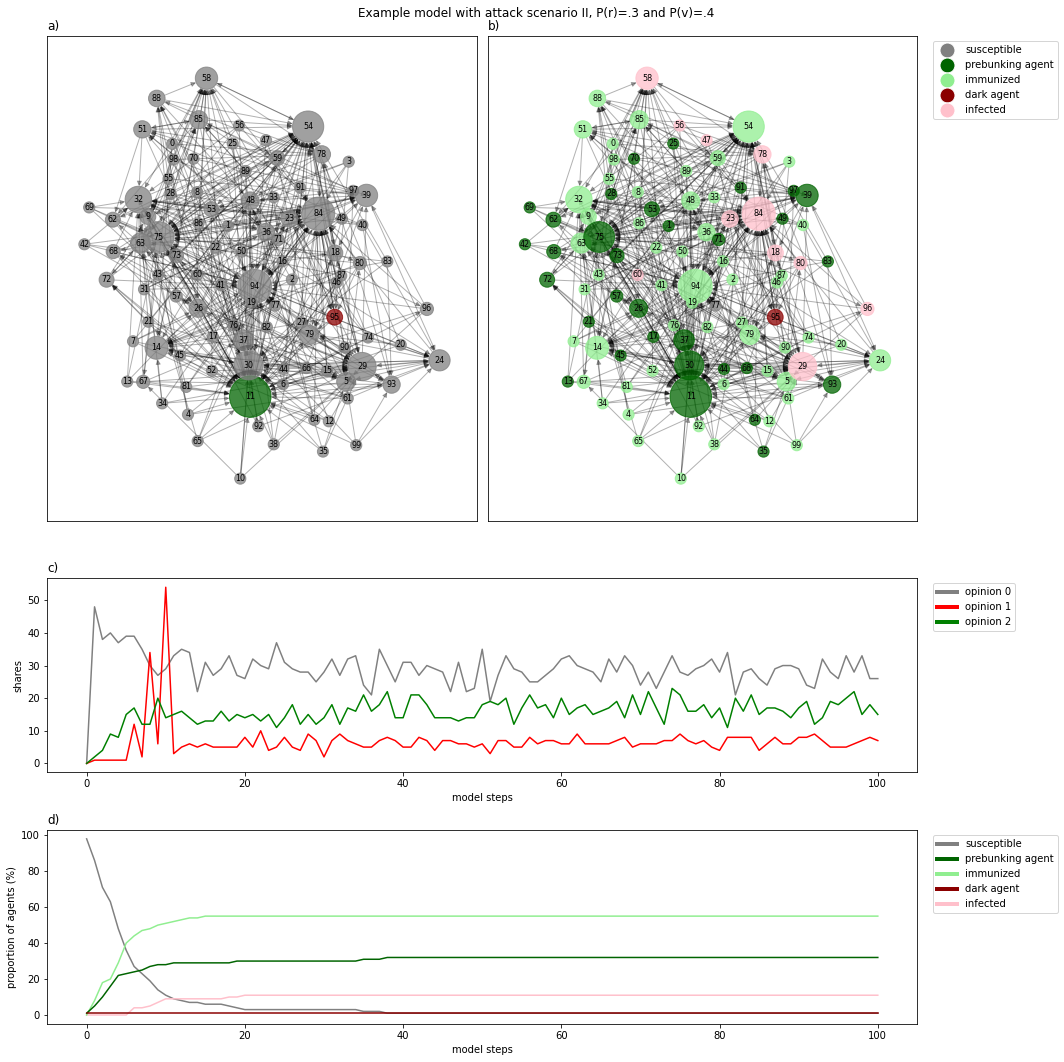

In [10]:
run_model(
    pop_size = 100,
    n_ticks = 100,
    n_friends = 5,
    n_add = 5,
    share_prob = .5,

    attack_start = 5,
    attack_kind = 1,
    atk_len=3,
    atk_str=50,
    decay=20,
    dark_quantile = .75,

    prebunk_prob = .3,
    vax_prob=.4,
    #draw = False,
    verbose=False,
    node_mult=25,
    custom_title='Example model with attack scenario II, P(r)=.3 and P(v)=.4',
    file_name='/home/dobby/Debunking/notebooks/figures/atk_2'
)

In [11]:
"""
Test all probabilities between 0 and 1 for becoming resistant and for becoming a prepunking agent oneself 
(P(v) and P(r), respectively)
"""
vaccination_probabilities = [np.round(i, 1) for i in np.arange(0, 1.1, .1)]
prebunking_probabilities = [np.round(i, 1) for i in np.arange(0, 1.1, .1)]

In [12]:
# Test all the probabilities of becoming resistant
gather_df = pd.DataFrame()
for p in tqdm(prebunking_probabilities):
    for v in tqdm(vaccination_probabilities):
        for x in tqdm(range(0, 3)):

            if x == 2:
                x_len = 5
            else:
                x_len = 3

            s_list = []
            i_list = []
            r_list = []
            for _ in range(100):
                add_dict = run_model(
                    pop_size=100,
                    n_ticks=100,
                    n_friends=5,
                    n_add=5,
                    share_prob=.5,

                    attack_start=5,
                    attack_kind=x,
                    atk_len=x_len,
                    atk_str=50,
                    decay=10,
                    dark_quantile=.75,

                    prebunk_prob=p,
                    vax_prob=v,
                    draw=False,
                    verbose=False
                )
                s_list.append(add_dict.get('n_s'))
                i_list.append(add_dict.get('n_i'))
                r_list.append(add_dict.get('n_r'))

            add_df = pd.DataFrame(dict(
                prebunking_prob=p,
                vaccination_prob=v,
                attack_kind=x,
                mean_susceptible=np.mean(s_list),
                mean_infected=np.mean(i_list),
                mean_resistant=np.mean(r_list)

            ), index=[0])
            gather_df = pd.concat([gather_df, add_df])


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
gather_df['mean_infected_prop'] = gather_df['mean_infected'] / 100

In [14]:
a = alt.Chart(gather_df[gather_df.attack_kind==0], title = 'Attack Type I').mark_line().encode(
    x=alt.X('prebunking_prob', title='P(r)'),
    y=alt.Y('mean_infected', title='mean infected (%)', scale=alt.Scale(domain=[0, 90])),
    color=alt.Color('vaccination_prob', title='P(v)'),
)

b = alt.Chart(gather_df[gather_df.attack_kind==1], title = 'Attack Type II').mark_line().encode(
    x=alt.X('prebunking_prob', title='P(r)'),
    y=alt.Y('mean_infected', title='mean infected (%)', scale=alt.Scale(domain=[0, 90])),
    color=alt.Color('vaccination_prob', title='P(v)'),
)

c = alt.Chart(gather_df[gather_df.attack_kind==2], title = 'Attack Type III').mark_line().encode(
    x=alt.X('prebunking_prob', title='P(r)'),
    y=alt.Y('mean_infected', title='mean infected (%)', scale=alt.Scale(domain=[0, 90])),
    color=alt.Color('vaccination_prob', title='P(v)'),
)

In [15]:
(a & b & c)

alt.VConcatChart(...)